In [28]:
import sys

import control as ct
# import sympy
# from sympy.plotting import plot
import sympy as sp
import numpy as np
# import penbegone as pbg
from penbegone import common as bgcom
# from penbegone import plotting as bgplot
# from penbegone.common import printeq

sys.path.append("..")

import plant as p

values = {}  # The dictionary holding values for the symbolic variables.

%matplotlib inline
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Create a simplified longitudinal model.

In [29]:
nllm = p.build_longitudinal_nonlinear_model()

variables = [p.pitch, p.throttle, p.v, p.h]
throttle_0 = sp.symbols("throttle_0")
v_0 = sp.symbols("v_0")
h_0 = sp.symbols("h_0")
trim = [p.theta_0, throttle_0, v_0, h_0]
states = [p.v, p.h]
derivatives = [p.v_dot, p.h_dot]

nllm.show()

[1]: $v_{dot}$ = $\frac{- 0.5 C_{drag} S \rho v^{2} + F_{t} \delta_{t} - g \sin{\left(\theta \right)}}{m}$

[2]: $h_{dot}$ = $v \sin{\left(\theta - \theta_{0} \right)}$

Linearize the model.

In [30]:
llm = bgcom.Equations()
for x, f in zip(derivatives, nllm):
    f = f+x  # Do not include the derivative in the linearization.
    llm.add(x, bgcom.linearize(f, variables, trim))

llm.show()

[1]: $v_{dot}$ = $- \frac{1.0 C_{drag} S \rho v_{0} \left(v - v_{0}\right)}{m} + \frac{F_{t} \left(\delta_{t} - throttle_{0}\right)}{m} - \frac{g \left(\theta - \theta_{0}\right) \cos{\left(\theta_{0} \right)}}{m} + \frac{- 0.5 C_{drag} S \rho v_{0}^{2} + F_{t} throttle_{0} - g \sin{\left(\theta_{0} \right)}}{m}$

[2]: $h_{dot}$ = $v_{0} \left(\theta - \theta_{0}\right)$

Trim around zero.

In [31]:
values[p.theta_0] = 0
values[throttle_0] = 0
values[v_0] = 20
values[h_0] = 0

llm.subs(values)
llm.show(show_all=True)

[1]: $v_{dot}$ = $- \frac{20.0 C_{drag} S \rho \left(v - 20\right)}{m} - \frac{200.0 C_{drag} S \rho}{m} + \frac{F_{t} \delta_{t}}{m} - \frac{g \theta}{m}$

[2]: $h_{dot}$ = $20 \theta$

Assign values to calculate the pole-zero plot.

In [32]:
values[p.rho] = 1.225
values[p.m] = 10
values[p.S] = 1
values[p.c_drag] = 0.2
values[p.F_t] = 30
values[p.g] = 9.81
llm.subs(values)
llm.show(show_all=True)

[1]: $v_{dot}$ = $3 \delta_{t} - 0.981 \theta - 0.49 v + 4.9$

[2]: $h_{dot}$ = $20 \theta$

[-0.49+0.j  0.  +0.j]
[0.+0.j]


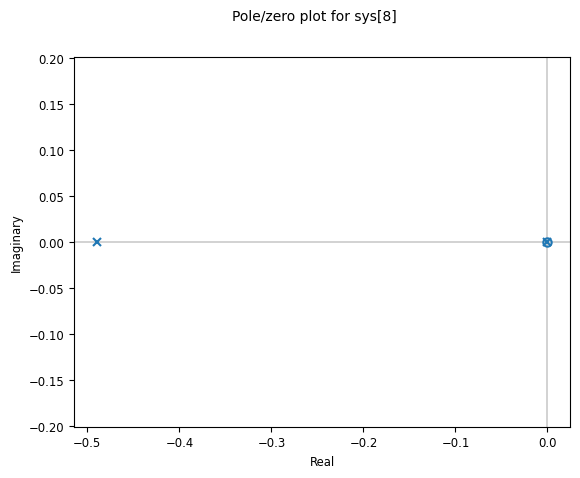

In [48]:
states = [p.v, p.h]
inputs = [p.pitch, p.throttle]

A = np.zeros((2,2))
A[0][0] = llm.rht[1].coeff(states[0])
A[1][1] = llm.rht[2].coeff(states[1])

B = np.zeros((2,1))
B[0][0] = llm.rht[1].coeff(inputs[0])
B[1][0] = llm.rht[2].coeff(inputs[1])

C = np.ones((1,2))
D = np.zeros((1,1))

aircraft = ct.ss(A, B, C, D)
print(aircraft.poles())
print(aircraft.zeros())
response = ct.pole_zero_plot(aircraft)
